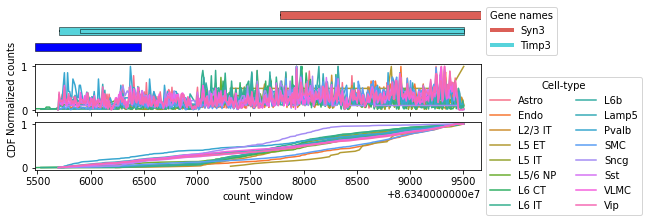

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import collections

import glob
import re
import os

pd.set_option('mode.chained_assignment', None)

#Paths to files and region to plot
gtf_path = '/oak/stanford/groups/horence/rob/readzs_fork/gencode.vM10.annotation.gff3'

stem = '/oak/stanford/groups/horence/rob/readzs_fork/results'
counts_path = os.path.join(stem,'counts','20220119_MERF_genes_SS2_chr10.txt')
zscore_path = os.path.join(stem,'zscore','20220119_MERF_genes_SS2_chr10.zscore')

region = ('chr10',86345473,86349665)

#Read in a gtf of the matching organism/annotation
gtf_df = pd.read_csv(
    gtf_path,
    comment = '#',
    sep = '\t',
    header = None,
    names = ['chrom','source','kind','start','stop','dot1','strand','dot2','info'],
)
gtf_df = gtf_df[gtf_df['kind'].isin(['exon','five_prime_UTR','three_prime_UTR'])] #subsetting to only exons/UTRs
gtf_df['gene_name'] = gtf_df['info'].str.extract('gene_name=(.*?);')
gtf_df['transcript_id'] = gtf_df['info'].str.extract('transcript_id=(.*?);')

#gtf_df.head()
#   chrom   source  kind    start     stop dot1 strand dot2  \
#2   chr1   HAVANA  exon  3073253  3074322    .      +    .   
#5   chr1  ENSEMBL  exon  3102016  3102125    .      +    .   
#8   chr1   HAVANA  exon  3213609  3216344    .      -    .   
#9   chr1   HAVANA  exon  3205901  3207317    .      -    .   
#11  chr1   HAVANA  exon  3213439  3215632    .      -    .   
#
#                                                 info      gene_name  \
#2   ID=exon:ENSMUST00000193812.1:1;Parent=ENSMUST0...  4933401J01Rik   
#5   ID=exon:ENSMUST00000082908.1:1;Parent=ENSMUST0...        Gm26206   
#8   ID=exon:ENSMUST00000162897.1:1;Parent=ENSMUST0...           Xkr4   
#9   ID=exon:ENSMUST00000162897.1:2;Parent=ENSMUST0...           Xkr4   
#11  ID=exon:ENSMUST00000159265.1:1;Parent=ENSMUST0...           Xkr4   
#
#           transcript_id  
#2   ENSMUST00000193812.1  
#5   ENSMUST00000082908.1  
#8   ENSMUST00000162897.1  
#9   ENSMUST00000162897.1  
#11  ENSMUST00000159265.1  

counts_df = pd.read_csv(
    counts_path,
    sep='\t',
    header=None,
    names=['cell_id','chrom','pos','strand','count','sample','window'],
)

celltype_col_name = 'subclass_label' #subclass_label is the name of my "cell-type" column
zscore_df = pd.read_csv(zscore_path, sep='\t')
cell_id_to_cell_type = dict(zscore_df[['cell_id',celltype_col_name]].values) 

#Map the cell-type info from the zscore table into the counts table. this is the only column we need
counts_df['Cell-type'] = counts_df['cell_id'].map(cell_id_to_cell_type)

#counts_df.head()
#                   cell_id  chrom      pos strand  count sample  window  \
#0  SS2_SM-GE92H_S298_E1-50  chr10  8204742      +      1    SS2  chr10_   
#1   SS2_SM-D9D85_S31_E1-50  chr10  8204751      +      1    SS2  chr10_   
#2   SS2_SM-D9E5W_S04_E1-50  chr10  8204755      +      1    SS2  chr10_   
#3   SS2_SM-DD44L_S46_E1-50  chr10  8204755      +      1    SS2  chr10_   
#4  SS2_SM-GE935_S212_E1-50  chr10  8204755      +      1    SS2  chr10_   
#
#  Cell-type  
#0       Vip  
#1     Lamp5  
#2       Vip  
#3       Vip  
#4       NaN  

def plot_read_buildup(region,readzs_df,gtf_df,ws=10,scale_bar_size=5000):
    """
    Arguments:
        region = ("chr10",3400,3700) <-- example
        readzs_df is a pd.DataFrame that has chrom/pos/strand/count/Cell-type columns
        gtf_df is a pd.DataFrame that has chrom/kind/start/stop/strand/gene_name/transcript_id columns
        ws is the "window-size" for binning the plots
        scale_bar_size is how big to make a blue scale-bar in the bottom left of the plots
        
        can add strand-specific plotting in somehow, not too many edits?
    """
    chrom,start,stop = region

    #subset the gtf and counts table
    count_df = readzs_df[
        readzs_df['chrom'].eq(chrom) &
        (readzs_df['pos'].between(start,stop) | readzs_df['pos'].between(start,stop))
    ]
    bins = np.arange(start,stop,ws)
    count_df['count_window'] = pd.cut(count_df['pos'], bins=bins, labels=bins[:-1])
    
    ann_df = gtf_df[
        gtf_df['chrom'].eq(chrom) &
        (gtf_df['start'].between(start,stop) | gtf_df['stop'].between(start,stop))
    ]
    
    genes = ann_df['gene_name'].unique()
    gene_colors = {g:c for g,c in zip(genes,sns.color_palette('hls', len(genes)))}

    fig,axs = plt.subplots(
        nrows=3,ncols=1,sharex=True,
        figsize=(8,3),
    )
    ann_ax = axs[0]
    count_ax = axs[1]
    cdf_ax = axs[2]

    ymin,ymax = 0,0

    for i,(transcript_id,transcript_df) in enumerate(ann_df.groupby('transcript_id')):
        y = 2*(i+1)
        #Draw a line for the intro from the total start to total end
        min_x_transcript = transcript_df['start'].min()
        max_x_transcript = transcript_df['stop'].max()

        intron_line = Rectangle(
            (min_x_transcript, y - 0.1),
            max_x_transcript - min_x_transcript, 0.2,
            linewidth=1,edgecolor='k',facecolor='k',
        )
        ann_ax.add_patch(intron_line)

        prev_5UTR = False
        prev_3UTR = False
        for _,feature in transcript_df.iterrows():
            height = 1
            #Sometimes there are multiple 5' and 3' UTRs for a single transcript (???) just use the first of each for now
            if feature['kind'] == 'five_prime_UTR':
                if prev_5UTR:
                    continue
                prev_5UTR = True
                height = 0.5

            if feature['kind'] == 'three_prime_UTR':
                if prev_3UTR:
                    continue
                prev_3UTR = True
                height = 0.5

            ymax = y+1

            x = feature['start']

            width = feature['stop']-feature['start']

            rect = Rectangle(
                (x, y - height/2),
                width, height,
                linewidth=0.5,edgecolor='k',facecolor=gene_colors[feature['gene_name']],
            )
            ann_ax.add_patch(rect)

    scale = Rectangle(
        (start, -0.5),
        scale_bar_size, 1,
        linewidth=0.5,edgecolor='k',facecolor='blue',
    )
    ann_ax.add_patch(scale)

    ann_ax.set_xlim(start,stop)
    ann_ax.set_ylim(-1,ymax)
    ann_ax.axis('off')

    handles = [Line2D([0],[0], color=gene_colors[g], lw=4) for g in genes]
    ann_ax.legend(
        handles, genes,
        title='Gene names',
        loc='center left',
        bbox_to_anchor=(1, 0.5),
    )

    #Now plotting the CDFs of counts stratified by Cell-type
    count_df = count_df.groupby(['Cell-type','count_window'], observed=True)['count'].sum().reset_index()
    
    count_df['Normalized counts'] = count_df.groupby('Cell-type')['count'].apply(lambda v: v/max(v))
    count_df['cum_sum'] = count_df.groupby('Cell-type')['count'].cumsum()
    count_df['CDF'] = count_df.groupby('Cell-type')['cum_sum'].apply(lambda v: v/max(v))

    sns.lineplot(
        x = 'count_window',
        y = 'Normalized counts',
        hue = 'Cell-type',
        data = count_df,
        legend = False,
        ax = count_ax,
    )

    sns.lineplot(
        x = 'count_window',
        y = 'CDF',
        hue = 'Cell-type',
        data = count_df,
        ax = cdf_ax,
    )
    cdf_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cell-type', ncol=2)

    
    return fig

#call the plotting function
fig = plot_read_buildup(region,counts_df,gtf_df,ws=10,scale_bar_size=1000)
plt.show()
plt.close()